In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from ML_core import Unet,Unet_2L
import DA_core as DA
import importlib
import torch
from os.path import exists
from torchsummary import summary
DA_kwargs={}

INFO:  Logger initialized


In [ ]:
importlib.reload(DA)

Workflow to run DA in PyQG

Things to decide first:
1. What are your "truth" and DA models: resolution (Nx_truth & Nx_DA), model parameters (set in DA_core), etc.
2. What are the frequency, density and error of sampling the observations

Files you need:
1. IC_q_Nx{Nx_DA}_ens{1/100}.nc
Spin up the model for initial conditions (ens_spinup): nens=1 for control and 3DVar, nens=100 for EnKF
2. Truth_Nx{Nx_truth}_*years.nc and Obs_Nx{Nx_truth}_freq{obs_freq}_nobs{*_*}_err{*_*}.nc
Run a control simulation and sample observations from it
3. B_Nx{Nx_DA}_*years_2lev.nc
Run a longer control simulation to sample the static background covariance for 3DVar or hybrid DA
4. W_Nx{Nx_DA}_L*.nc
Generate localization weights for specific DA model and localization radius

Run DA experiment!

In [2]:
# Setting up the truth, obs, etc
DA_setup_paras={'nens':1,
                'Nx_DA':32,          
                'Nx_truth':128,          
                'obs_freq':10,          
                'obs_err':[1,-5,5,-7],          
                'nobs':[50,50]}
DA_setup=DA.DA_exp(**DA_setup_paras)

In [3]:
ds_truth=DA_setup.read_truth(years=20)
# ds_truth.q.isel(time=7299,lev=0).plot(size=10)
patch_std=np.empty((2,31,31))
for i in range(31):
    for j in range(31):
        patch=ds_truth.q.isel(x=slice(i*4,i*4+4),y=slice(j*4,j*4+4))
        patch_std[:,i,j]=(patch.max(dim=('x','y'))-patch.min(dim=('x','y'))).mean('time').values

plt.contourf(patch_std[0,:,:])
plt.colorbar()

KeyboardInterrupt: 

In [ ]:
plt.contourf(patch_std[1,:,:])
plt.colorbar()

INFO:  Logger initialized


<xarray.DataArray 'q' (model: 1, time: 7300, lev: 2, y: 128, x: 128)>
[239206400 values with dtype=float64]
Coordinates:
  * time     (time) timedelta64[ns] 1 days 2 days 3 days ... 7299 days 7300 days
  * lev      (lev) int64 1 2
  * x        (x) float64 3.906e+03 1.172e+04 1.953e+04 ... 9.883e+05 9.961e+05
  * y        (y) float64 3.906e+03 1.172e+04 1.953e+04 ... 9.883e+05 9.961e+05
Dimensions without coordinates: model
Attributes:
    long_name:  potential vorticity in real space
    units:      meters squared Kelvin per second per kilogram


100%|██████████| 15/15 [01:48<00:00,  7.24s/it]


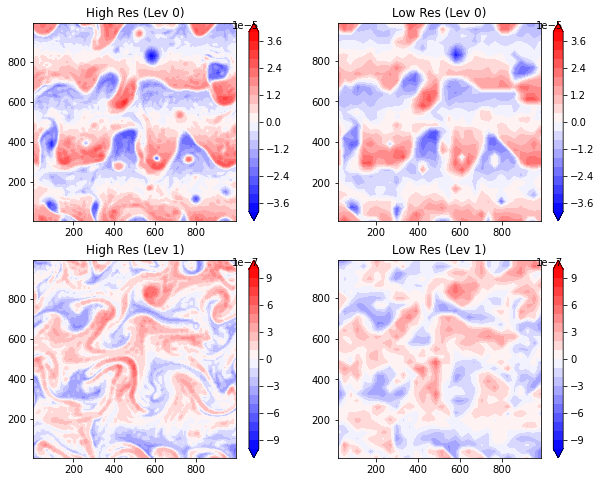

In [4]:
# Coarsen resolution
DA_setup.hires_to_lores(years=20)

q_lo_ds=DA_setup.read_truth(years=20,interp=True)
q_hi_ds=xr.open_dataset(q_lo_ds.attrs['source_file'])

select_day=1825
q_low=q_lo_ds.q.isel(time=select_day).squeeze('model')
q_hi=q_hi_ds.q.isel(time=select_day).squeeze('model')
fig, axes=plt.subplots(2,2,figsize=(10,8))
for j,q,s in zip(range(2),[q_hi,q_low],["High","Low"]):
    for i,clim in enumerate([4.0E-5,1.0E-6]):
        im=axes[i,j].contourf(q.x/1.0E3,q.y/1.0E3,q.isel(lev=i),cmap='bwr',extend='both',
                              levels=np.linspace(-clim,clim,21,endpoint=True))
        plt.colorbar(im,ax=axes[i,j])
        axes[i,j].set_title('{} Res (Lev {})'.format(s,i))

In [ ]:
## Spin up the model for IC
q_init=DA_setup.ens_spinup(years=25)
q_init

In [ ]:
## Generate "truth"/control simulation
try:
    ds_truth=DA_setup.read_truth(years=10)
except:
    ds_truth=DA_setup.generate_truth(years=10)
print(ds_truth)

## Generate or read observations
if exists(DA_setup.obs_name()):
    obs_ds=DA_setup.read_obs()
else:
    obs_ds=DA_setup.generate_obs(years=10)

print(obs_ds)

## Visualize the generated observations
truth_file=obs_ds.attrs['truth_file']
truth_ds=xr.open_dataset(truth_file)

select_day=9
q=truth_ds.q.isel(time=select_day).squeeze('model')
obs_q=obs_ds.q.isel(day=select_day)
xi_q=obs_ds.xi.isel(day=select_day)
yi_q=obs_ds.yi.isel(day=select_day)
li_q=obs_ds.li.isel(day=select_day)
x_q=obs_ds.x.data[xi_q]
y_q=obs_ds.y.data[yi_q]
fig, axes=plt.subplots(1,2,figsize=(16,6))
for i in range(len(q.lev)):
    im=axes[i].contourf(q.x,q.y,q.isel(lev=i),cmap='bwr',levels=20)
    plt.colorbar(im,ax=axes[i])
    
    axes[i].scatter(x_q[li_q==i],y_q[li_q==i],c='k')
    axes[i].set_title('q (lev {}, {})'.format(i,np.timedelta64(q.time.values,'D')))

In [ ]:
## Generate "truth"/control simulation
ds_truth=DA_setup.generate_truth(years=100)
print(ds_truth)

# Calculate B matrix for 3DVar
B_ds=DA.B_calculation_3DVar(Nx=DA_setup.Nx_DA,years=100)

select_x,select_y=np.array([20,20,20]),np.array([10,20,30])

fig, axes=plt.subplots(len(select_x),3,figsize=(15,4*len(select_x)))
for j,x,y in zip(range(len(select_x)),select_x,select_y):
    xy0=x+y*DA_setup.Nx_DA
    xy1=x+y*DA_setup.Nx_DA+DA_setup.Nx_DA*DA_setup.Nx_DA
    corr_xy0=B_ds.corr.data[xy0,:].reshape(2,DA_setup.Nx_DA,DA_setup.Nx_DA)
    corr_xy1=B_ds.corr.data[xy1,:].reshape(2,DA_setup.Nx_DA,DA_setup.Nx_DA)

    im=axes[j,0].contourf(B_ds.x/1.0E3,B_ds.y/1.0E3,corr_xy0[0,:,:],cmap='bwr',levels=np.linspace(-1.05,1.05,22,endpoint=True))
    plt.colorbar(im,ax=axes[j,0])
    axes[j,0].set_title('Lev 0-0 correlation (y={},x={})'.format(y,x))

    im=axes[j,1].contourf(B_ds.x/1.0E3,B_ds.y/1.0E3,corr_xy0[1,:,:],cmap='bwr',levels=np.linspace(-1.05,1.05,22,endpoint=True))
    plt.colorbar(im,ax=axes[j,1])
    axes[j,1].set_title('Lev 0-1 correlation (y={},x={})'.format(y,x))

    im=axes[j,2].contourf(B_ds.x/1.0E3,B_ds.y/1.0E3,corr_xy1[1,:,:],cmap='bwr',levels=np.linspace(-1.05,1.05,22,endpoint=True))
    plt.colorbar(im,ax=axes[j,2])
    axes[j,2].set_title('Lev 1-1 correlation (y={},x={})'.format(y,x))

In [9]:
for seed in [7,8,9,10]:
    for nens,relax in zip([1],[0.]):
        DA_paras={'nens':nens,
                'DA_method':'3DVar',
                'Nx_DA':32,
                'Nx_truth':128,
                'obs_freq':10,
                'obs_err':[1,-5,5,-7],
                'nobs':[50,50],
                'R_W':50,
                'DA_freq':10,
                'save_B':False,
                'inflate':[1,relax],
                'output_str':''}
        DA_exp=DA.DA_exp(**DA_paras)
        DA_exp.run_exp(DA_days=7300,DA_start=0,ic_seed=seed,**DA_kwargs)

INFO:  Logger initialized


/scratch/cimes/feiyul/PyQG/data//Obs_Nx128_freq10_nobs50_50_err1E-5_5E-7.nc
/scratch/cimes/feiyul/PyQG/data/IC_q_Nx32_ens100.nc


100%|██████████| 730/730 [02:52<00:00,  4.22it/s]
INFO:  Logger initialized


/scratch/cimes/feiyul/PyQG/data//Obs_Nx128_freq10_nobs50_50_err1E-5_5E-7.nc
/scratch/cimes/feiyul/PyQG/data/IC_q_Nx32_ens100.nc


100%|██████████| 730/730 [02:50<00:00,  4.27it/s]
INFO:  Logger initialized


/scratch/cimes/feiyul/PyQG/data//Obs_Nx128_freq10_nobs50_50_err1E-5_5E-7.nc
/scratch/cimes/feiyul/PyQG/data/IC_q_Nx32_ens100.nc


100%|██████████| 730/730 [02:50<00:00,  4.29it/s]
INFO:  Logger initialized


/scratch/cimes/feiyul/PyQG/data//Obs_Nx128_freq10_nobs50_50_err1E-5_5E-7.nc
/scratch/cimes/feiyul/PyQG/data/IC_q_Nx32_ens100.nc


100%|██████████| 730/730 [02:49<00:00,  4.31it/s]


In [2]:
# Setting up DA experiment what was used to train Unet
DA_training_paras={'nens':320,
                   'DA_method':'EnKF',
                   'Nx_DA':64,
                   'Nx_truth':128,
                   'obs_freq':10,
                   'obs_err':[1,-5,5,-7],
                   'DA_freq':10,
                   'save_B':False,
                   'nobs':[50,50],
                   'R_W':100,
                   'inflate':[1,0.45]}
DA_training=DA.DA_exp(**DA_training_paras)

In [3]:
# Read trained Unet and normalization factors (standard deviations)
in_ch=[0,1]
out_ch=[0,1,2]
epoch=49
R_training=12
R_DA=12
features=32
Ulevels=2
if Ulevels==3:
    model=Unet(in_ch=len(in_ch),out_ch=len(out_ch),features=features).double()
elif Ulevels==2:
    model=Unet_2L(in_ch=len(in_ch),out_ch=len(out_ch),features=features).double()
model_file='./ML/{}/{}L_{}f/unet_epoch{}_in{}_out{}_B{}_{}.pt'.format(
    DA_training.file_name(),Ulevels,features,epoch,''.join(map(str,in_ch)),''.join(map(str,out_ch)),R_training*2,DA_training.file_name())
# model_file='./ML/unet_in{}_out{}_{}.pt'.format(''.join(map(str,in_ch)),''.join(map(str,out_ch)),DA_training.file_name())
print(model_file)
model.load_state_dict(torch.load(model_file))
model.eval()
ml_std_ds=xr.open_dataset('./ML/{0}/std_{0}.nc'.format(DA_training.file_name()))


./ML/EnKF_Nx64_from_Nx128_ens320_freq10_relax0.45_R100_nobs50_50_err1E-5_5E-7/2L_32f/unet_epoch49_in01_out012_B24_EnKF_Nx64_from_Nx128_ens320_freq10_relax0.45_R100_nobs50_50_err1E-5_5E-7.pt


In [4]:
for R_W in [100]:
    for nens,relax in zip([1],[0.0]):
        DA_paras={'nens':nens,
                'DA_method':'UnetKF',
                'Nx_DA':64,
                'Nx_truth':128,
                'obs_freq':10,
                'obs_err':[1,-5,5,-7],
                'nobs':[50,50],
                'R_W':R_W,
                'DA_freq':10,
                'save_B':False,
                'inflate':[1,relax],
                'B_alpha':0.0,
                'R_training':R_training,
                'R_DA':R_DA,
                'training_exp':DA_training}
        DA_exp=DA.DA_exp(**DA_paras)
        
        DA_kwargs['ml_model']=model
        DA_kwargs['ml_std_ds']=ml_std_ds
        DA_kwargs['output_str']=''
        DA_kwargs['output_str']='UnetKF_Nx{}_128_ens{}_{}L{}f'.format(DA_exp.Nx_DA,DA_training.nens,Ulevels,features)

        DA_exp.run_exp(DA_days=7300,DA_start=0,**DA_kwargs)

INFO:  Logger initialized


/scratch/cimes/feiyul/PyQG/data//Obs_Nx128_freq10_nobs50_50_err1E-5_5E-7.nc
/scratch/cimes/feiyul/PyQG/data/IC_q_Nx64_ens100.nc


100%|██████████| 730/730 [1:27:22<00:00,  7.18s/it]


In [ ]:
# Static localization weight matrix
Nx_DA=DA_setup.Nx_DA
R=75.0E3

W_ds=DA.Localize_weights(Nx=Nx_DA,R=R,save_netcdf=True)
# W_ds=xr.open_dataset('{}/W_Nx{}_L{}.nc'.format(data_dir,Nx_DA,int(R/1000)))

select_x,select_y,select_l=10,10,0
select_xy=select_x+select_y*Nx_DA+select_l*Nx_DA*Nx_DA
W_xy=W_ds.W.data[select_xy,:].reshape(2,Nx_DA,Nx_DA)

fig, axes=plt.subplots(1,2,figsize=(10,4))
for i in range(2):
    im=axes[i].contourf(W_ds.x/1.0E3,W_ds.y/1.0E3,W_xy[i,:,:],cmap='bwr',levels=np.linspace(-1.05,1.05,22,endpoint=True))
    plt.colorbar(im,ax=axes[i])
    axes[i].set_title('Lev {} Localization weight to (lev={},y={},x={})'.
                      format(i,select_l,select_y,select_x))

In [ ]:
DA.read_data_dir='/scratch/cimes/feiyul/PyQG/data/training'
DA.save_data_dir='/scratch/cimes/feiyul/PyQG/data/training'
for R_W in [100]:
    for nens,relax in zip([80],[0.5]):
        DA_paras={'nens':nens,
                'DA_method':'EnKF',
                'Nx_DA':32,
                'Nx_truth':128,
                'obs_freq':10,
                'obs_err':[1,-5,5,-7],
                'nobs':[50,50],
                'R_W':R_W,
                'DA_freq':10,
                'save_B':True,
                'inflate':[1,relax],
                'output_str':''}
        DA_exp=DA.DA_exp(**DA_paras)
        DA_exp.run_exp(DA_days=3650,DA_start=0,**DA_kwargs)